## Reading in packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import string, re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carolineshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading in data

In [261]:
connection = sqlite3.connect('database.sqlite')
cursor = connection.cursor()

In [262]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [263]:
df_content

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...
...,...,...
18388,1535,The marketing guys of yer average modern megac...
18389,1341,"Well, it's been two weeks now, and I guess it'..."
18390,5376,"Out of Tune is a Steve Martin album. Yes, I'l..."
18391,2413,"Well, kids, I just went back and re-read my re..."


In [264]:
just_content = df_content['review']
just_content

0        “Trip-hop” eventually became a ’90s punchline,...
1        Eight years, five albums, and two EPs in, the ...
2        Minneapolis’ Uranium Club seem to revel in bei...
3        Kleenex began with a crash. It transpired one ...
4        It is impossible to consider a given release b...
                               ...                        
18388    The marketing guys of yer average modern megac...
18389    Well, it's been two weeks now, and I guess it'...
18390    Out of Tune is a Steve Martin album.  Yes, I'l...
18391    Well, kids, I just went back and re-read my re...
18392    Neil Hamburger's third comedy release is a des...
Name: review, Length: 18393, dtype: object

## Preprocessing review text

In [265]:
def processing_text(article):
    article = article.lower()
    
    tokenizer = RegexpTokenizer(r'(?u)\b[A-Za-z]+\b')
    tokens = tokenizer.tokenize(article)
    
    stopword_list = stopwords.words('english')
    stopword_list += ['like', 'song', 'album', 'music', 'sing']
    stopwords_removed = [word for word in tokens if not word in stopword_list]
    
    text = " ".join(stopwords_removed)
    
    lemmatizer = WordNetLemmatizer() 
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    stemmer = PorterStemmer()
    stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return stemmed

In [266]:
processing_text(just_content[18392])

'neil hamburg third comedi releas desper affair even sad sack america funnyman hamburg aka gregg turkington take routin kuala lumpur malaysia warm local karaok time bad nobodi audienc speak understand english broad setup knock hamburg usual pathet sampl joke mani spice girl take screw lightbulb well five four sure day three uh huhhhh earli show hamburg realiz one crowd speak english wors yet manag right hand man art huckman flee scene huff one left lean neil open past gig perform amway convent fail marriag littl someth call montezuma reveng funni realli point left dead malaysia forti minut flop sweat much might feel moist listen usual joke hamburg bigger loser planet guy ye flat routin left dead may think otherwis hamburg turkington precis hit desper nail squar head raw hamburg america funnyman fare lot better sure go anoth neil hamburg stage easili set loser sink even lower enjoy previou album enjoy left dead folk get joke realli joke seri empti shell fail observ classic hamburg'

In [267]:
df_content['processed'] = just_content.apply(lambda x: processing_text(x))

In [268]:
df_content

,id,review,processed
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",trip hop eventu becam punchlin press shorthand...
1,22721,"Eight years, five albums, and two EPs in, the ...",eight year five album two ep new york base out...
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,minneapoli uranium club seem revel aggress obt...
3,22661,Kleenex began with a crash. It transpired one ...,kleenex began crash transpir one night long fo...
4,22725,It is impossible to consider a given release b...,imposs consid given releas footwork artist wit...
...,...,...,...
18388,1535,The marketing guys of yer average modern megac...,market guy yer averag modern megaconglomer lov...
18389,1341,"Well, it's been two weeks now, and I guess it'...",well two week guess time tell guy someth cassi...
18390,5376,"Out of Tune is a Steve Martin album. Yes, I'l...",tune steve martin ye explain upon time steve m...
18391,2413,"Well, kids, I just went back and re-read my re...",well kid went back read review guy last burn n...


## Merging together all features into 1 DataFrame and pickling

In [269]:
query = "select * from reviews;"
cursor.execute(query)
reviews_df = pd.DataFrame(cursor.fetchall(), columns=['id','title','artist','url', 'score', 'best_new_music', 'author', 'author_type', \
                                                     'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year'])

In [270]:
query = "select * from genres;"
cursor.execute(query)
genre_df = pd.DataFrame(cursor.fetchall(), columns=['id','genre'])

In [271]:
genre_df = genre_df.drop_duplicates(subset='id', keep="first")
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 22679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18389 non-null  int64 
 1   genre   16024 non-null  object
dtypes: int64(1), object(1)
memory usage: 431.0+ KB


In [272]:
query = "select * from labels;"
cursor.execute(query)
labels_df = pd.DataFrame(cursor.fetchall(), columns=['id','label'])

In [273]:
labels_df = labels_df.drop_duplicates(subset='id', keep="first")
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 20189
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18389 non-null  int64 
 1   label   18351 non-null  object
dtypes: int64(1), object(1)
memory usage: 431.0+ KB


In [274]:
query = "select * from years;"
cursor.execute(query)
year_released_df = pd.DataFrame(cursor.fetchall(), columns=['id','year_released'])

In [275]:
year_released_df = year_released_df.drop_duplicates(subset='id', keep="first")
year_released_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 19107
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18389 non-null  int64  
 1   year_released  17983 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 431.0 KB


In [276]:
reviews_df = reviews_df.merge(genre_df, how='outer', on=['id'])

In [277]:
reviews_df = reviews_df.merge(labels_df, how='outer', on=['id'])

In [278]:
reviews_df = reviews_df.merge(year_released_df, how='outer', on=['id'])

In [279]:
df_content = df_content.merge(reviews_df, how='outer', on=['id'])

In [280]:
df_content

,id,review,processed,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre,label,year_released
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",trip hop eventu becam punchlin press shorthand...,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,electronic,virgin,1998.0
1,22721,"Eight years, five albums, and two EPs in, the ...",eight year five album two ep new york base out...,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,metal,hathenter,2016.0
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,minneapoli uranium club seem revel aggress obt...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,rock,static shock,2016.0
3,22661,Kleenex began with a crash. It transpired one ...,kleenex began crash transpir one night long fo...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,rock,kill rock stars,2016.0
4,22725,It is impossible to consider a given release b...,imposs consid given releas footwork artist wit...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,electronic,teklife,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18396,1535,The marketing guys of yer average modern megac...,market guy yer averag modern megaconglomer lov...,let us replay!,coldcut,http://pitchfork.com/reviews/albums/1535-let-u...,8.9,0,james p. wisdom,None,1999-01-26,1,26,1,1999,jazz,ninja tune,NaN
18397,1341,"Well, it's been two weeks now, and I guess it'...",well two week guess time tell guy someth cassi...,1999,cassius,http://pitchfork.com/reviews/albums/1341-1999/,4.8,0,james p. wisdom,None,1999-01-26,1,26,1,1999,electronic,astralwerks,NaN
18398,5376,"Out of Tune is a Steve Martin album. Yes, I'l...",tune steve martin ye explain upon time steve m...,out of tune,mojave 3,http://pitchfork.com/reviews/albums/5376-out-o...,6.3,0,jason josephes,contributor,1999-01-12,1,12,1,1999,rock,4ad,NaN
18399,2413,"Well, kids, I just went back and re-read my re...",well kid went back read review guy last burn n...,"singles breaking up, vol. 1",don caballero,http://pitchfork.com/reviews/albums/2413-singl...,7.2,0,james p. wisdom,None,1999-01-12,1,12,1,1999,rock,touch and go,1999.0


In [281]:
df_content.to_pickle("fulldf.pkl")

In [3]:
allreviews_df = pd.read_pickle("fulldf.pkl")

In [7]:
allreviews_df.to_csv('fulldf.csv')

## Count Vectorizer

In [4]:
cv = CountVectorizer()

In [285]:
words_cv = cv.fit_transform(allreviews_df['processed'])

In [286]:
cv_df = pd.DataFrame(words_cv.toarray(), columns = cv.get_feature_names()).head(20)

In [287]:
cv_df

,aa,aaa,aaaa,aaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaarrrggghhh,aaaaaah,aaaaah,aaaaay,...,zzk,zzt,zzz,zzzpenchant,zzzt,zzzyyi,zzzz,zzzzhk,zzzzzzzz,zzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Vectorizer

In [5]:
tfidf_vectorizer = TfidfVectorizer()

In [6]:
words_tfidf = tfidf_vectorizer.fit_transform(allreviews_df['processed'])

In [7]:
tfidf_df = pd.DataFrame(words_tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names()).head(20)

In [291]:
tfidf_df

,aa,aaa,aaaa,aaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaarrrggghhh,aaaaaah,aaaaah,aaaaay,...,zzk,zzt,zzz,zzzpenchant,zzzt,zzzyyi,zzzz,zzzzhk,zzzzzzzz,zzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF Vectorizer x NMF Topic Modeling

In [8]:
nmf = NMF(n_components=10, random_state=42)

In [9]:
nmf_fit = nmf.fit(words_tfidf)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [10]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [11]:
display_topics(nmf, tfidf_vectorizer.get_feature_names(), 15)


Topic  0
guitar, vocal, acoust, folk, song, instrument, melodi, voic, track, sound, piano, string, drum, open, sing

Topic  1
rap, rapper, hop, hip, beat, mixtap, produc, vers, lil, mc, wayn, product, sampl, rhyme, gucci

Topic  2
remix, hous, danc, track, disco, dj, mix, techno, synth, beat, electro, bass, pop, label, club

Topic  3
band, rock, punk, guitar, sound, group, indi, post, pop, riff, new, song, debut, member, vocal

Topic  4
metal, black, death, doom, riff, hardcor, minut, heavi, thrash, dark, guitar, drum, nois, one, blood

Topic  5
disc, record, live, version, releas, set, cover, perform, origin, year, compil, includ, song, one, collect

Topic  6
love, pop, song, feel, sing, lyric, life, girl, emot, self, voic, songwrit, indi, heart, dream

Topic  7
get, thing, good, go, know, realli, say, one, think, guy, peopl, make, even, time, want

Topic  8
pollard, gbv, guid, robert, bob, sprout, record, tobia, voic, song, rock, circu, suitcas, tobin, spaceship

Topic  9
sound, pie

In [12]:
topic_word = pd.DataFrame(nmf.components_.round(3),
             index = ["topic_1", "topic_2", 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10'],
             columns = tfidf_vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaarrrggghhh,aaaaaah,aaaaah,aaaaay,...,zzk,zzt,zzz,zzzpenchant,zzzt,zzzyyi,zzzz,zzzzhk,zzzzzzzz,zzzzzzzzzzzz
topic_1,0.000,0.002,0.001,0.0,0.0,0.0,0.001,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_2,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_3,0.002,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.001,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_4,0.004,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.002,0.000,0.0,0.000
topic_5,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_6,0.000,0.000,0.001,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_7,0.000,0.005,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_8,0.000,0.001,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.001
topic_9,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000
topic_10,0.004,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.001,0.001,0.000,0.0,0.0,0.0,0.000,0.001,0.0,0.000


In [13]:
topic_word_T = topic_word.T

In [14]:
topic_review = nmf.transform(words_tfidf)

topic_review_df = pd.DataFrame(topic_review).add_prefix('topic_')
topic_review_df['DESCRIPTIONS'] = allreviews_df['review']
topic_review_df['ALBUM_SCORE'] = allreviews_df['score']
topic_review_df['GENRE'] = allreviews_df['genre']

topic_review_df.dropna(inplace=True)

In [15]:
topic_review_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,DESCRIPTIONS,ALBUM_SCORE,GENRE
0,0.000000,0.020563,0.022193,0.010807,0.007764,0.025901,0.029798,0.011180,0.000839,0.013550,"“Trip-hop” eventually became a ’90s punchline,...",9.3,electronic
1,0.000000,0.001574,0.005344,0.019697,0.048779,0.011272,0.003738,0.000415,0.002931,0.009457,"Eight years, five albums, and two EPs in, the ...",7.9,metal
2,0.000000,0.003451,0.016324,0.041629,0.002708,0.005255,0.004498,0.016212,0.000000,0.000863,Minneapolis’ Uranium Club seem to revel in bei...,7.3,rock
3,0.003374,0.000331,0.005004,0.022077,0.004904,0.013042,0.016710,0.011672,0.000000,0.007906,Kleenex began with a crash. It transpired one ...,9.0,rock
4,0.002685,0.015080,0.044811,0.000000,0.000215,0.007822,0.001089,0.000317,0.002349,0.010991,It is impossible to consider a given release b...,8.1,electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,0.000000,0.000000,0.032149,0.000000,0.000000,0.000000,0.000000,0.027654,0.000000,0.034266,When I picked up Pole's first CD (humorlessly ...,7.2,electronic
18396,0.000000,0.004477,0.016050,0.000000,0.002818,0.013844,0.006383,0.035433,0.000000,0.000000,The marketing guys of yer average modern megac...,8.9,jazz
18397,0.000000,0.000000,0.063334,0.000000,0.000000,0.000000,0.000000,0.040693,0.000000,0.000000,"Well, it's been two weeks now, and I guess it'...",4.8,electronic
18398,0.011883,0.000000,0.000000,0.000000,0.001719,0.018270,0.008314,0.073083,0.000000,0.000000,"Out of Tune is a Steve Martin album. Yes, I'l...",6.3,rock


In [16]:
def Hot_Topic(df,topic,num):
    for Description in df.sort_values(by=topic, ascending=False).head(num)['DESCRIPTIONS'].values:
        print(Description)
        print()

def Hot_Words(df,topic,num):
    HW = df.sort_values(by=topic, ascending=False).head(num)
    return HW

In [108]:
Hot_Topic(topic_review_df, 'topic_9', 10)

Abstract electronic music is exciting in part because it sounds like it
    comes from its own world. There is no material reference point for something
    like Oval's Szenariodisk or Autechre's EP7. No object and no
    living thing can make these sounds; they are instead birthed from the
    unknowable guts of a cold, calculating machine. It is these limitless
    sonic possibilities that have driven composers to electronic music since
    before John Cage was calling his early experiments "Imaginary Landscapes."
    
    But there's also something to be said for electronic music that remains
    grounded, emotionally accessible, and clearly of this earth. And it's in
    this class of electronic records that Twine's Recorder falls. Rather
    than sounding like the outgrowth of endless experiment, Recorder sounds
    like it was laid out carefully before the first mouse had been clicked, the
    whole thing designed to realize very specific musical goals. This is no pile-up
    of 

## Count Vectorizer x LDA Topic Modeling

In [304]:
lda = LatentDirichletAllocation(n_components = 10, n_jobs = -1, random_state = 42)

In [305]:
lda_fit = lda.fit(words_cv)

In [306]:
display_topics(lda, cv.get_feature_names(), 10)


Topic  0
band, rock, sound, one, record, song, guitar, make, even, get

Topic  1
track, one, rap, sound, beat, make, year, get, even, hop

Topic  2
band, metal, sound, one, track, guitar, rock, record, black, minut

Topic  3
song, band, record, one, sound, pop, time, rock, even, make

Topic  4
sound, track, record, one, work, guitar, feel, make, time, vocal


In [307]:
lda_topic_word = pd.DataFrame(nmf.components_.round(3),
             index = ["topic_1", "topic_2", 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10'],
             columns = tfidf_vectorizer.get_feature_names())
lda_topic_word

,aa,aaa,aaaa,aaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaarrrggghhh,aaaaaah,aaaaah,aaaaay,...,zzk,zzt,zzz,zzzpenchant,zzzt,zzzyyi,zzzz,zzzzhk,zzzzzzzz,zzzzzzzzzzzz
component_1,0.000,0.004,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000
component_2,0.001,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000
component_3,0.003,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000
component_4,0.002,0.001,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.001
component_5,0.001,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000


In [308]:
lda_topic_review = lda.transform(words_tfidf)

lda_topic_review_df = pd.DataFrame(lda_topic_review).add_prefix('topic_')
lda_topic_review_df['DESCRIPTIONS'] = allreviews_df['review']
lda_topic_review_df['ALBUM_SCORE'] = allreviews_df['score']
lda_topic_review_df['GENRE'] = allreviews_df['genre']

lda_topic_review_df.dropna(inplace=True)

In [309]:
lda_topic_review_df

,topic_0,topic_1,topic_2,topic_3,topic_4,DESCRIPTIONS,ALBUM_SCORE,GENRE
0,0.013828,0.546507,0.405849,0.022419,0.011397,"“Trip-hop” eventually became a ’90s punchline,...",9.3,electronic
1,0.015191,0.015114,0.939294,0.015240,0.015161,"Eight years, five albums, and two EPs in, the ...",7.9,metal
2,0.930286,0.017621,0.017372,0.017351,0.017370,Minneapolis’ Uranium Club seem to revel in bei...,7.3,rock
3,0.323569,0.014334,0.014490,0.633135,0.014471,Kleenex began with a crash. It transpired one ...,9.0,rock
4,0.021145,0.915043,0.021168,0.021122,0.021522,It is impossible to consider a given release b...,8.1,electronic
...,...,...,...,...,...,...,...,...
18395,0.210920,0.021806,0.021360,0.021432,0.724482,When I picked up Pole's first CD (humorlessly ...,7.2,electronic
18396,0.242835,0.699648,0.019318,0.018963,0.019236,The marketing guys of yer average modern megac...,8.9,jazz
18397,0.020396,0.418692,0.020664,0.519530,0.020718,"Well, it's been two weeks now, and I guess it'...",4.8,electronic
18398,0.013438,0.281659,0.013456,0.678008,0.013440,"Out of Tune is a Steve Martin album. Yes, I'l...",6.3,rock


## Running Random Forest Regressor with just TF-IDF/NMF topics as features

In [18]:
X = topic_review_df.iloc[:, 0:10]
y = topic_review_df.ALBUM_SCORE

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
randomforest = RandomForestRegressor(n_estimators=100)
randomforest.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
y_train_pred = randomforest.predict(X_train)

In [22]:
act_pred_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Residual': abs(y_train-y_train_pred)})

In [23]:
act_pred_df

,Actual,Predicted,Residual
7572,6.9,6.922,0.022
8090,7.0,7.033,0.033
6522,6.7,6.964,0.264
8490,7.1,6.704,0.396
3776,7.1,6.839,0.261
...,...,...,...
15423,6.6,7.010,0.410
6437,7.5,7.273,0.227
917,8.6,8.361,0.239
18149,7.9,7.369,0.531


In [24]:
ridge_test_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
ridge_test_mae = mean_absolute_error(y_train, y_train_pred)

ridge_test_r2 = randomforest.score(X_train, y_train)

print(ridge_test_rmse)
print(ridge_test_mae)
print(ridge_test_r2)

0.4642017704914643
0.3422625332281914
0.8725419752898634


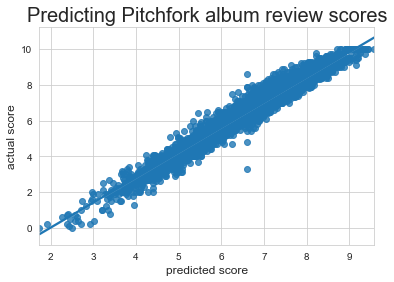

<Figure size 1080x1080 with 0 Axes>

In [25]:
sns.set_style('whitegrid') 

sns.regplot(data = topic_review_df, x=y_train_pred, y=y_train)

plt.title('Predicting Pitchfork album review scores', fontsize = 20)
plt.ylabel('actual score', fontsize=12)
plt.xlabel('predicted score', fontsize=12)

plt.figure(figsize=(15,15));

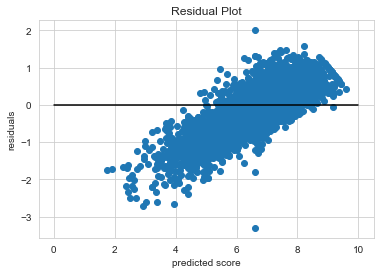

<Figure size 1080x1080 with 0 Axes>

In [26]:
residuals = y_train-y_train_pred

plt.scatter(y_train_pred, residuals)
plt.plot([0,10], [0,0], color='black')

plt.title("Residual Plot")
plt.xlabel("predicted score")
plt.ylabel("residuals")
plt.figure(figsize=(15,15));

## Running Elastic Net Regressor -- giving me weird metrics

In [128]:
elastic_net = ElasticNet(alpha=0.202)
elastic_net.fit(X_train, y_train)

elastic_preds = elastic_net.predict(X_train)

elastic_test_r2 = elastic_net.score(X_train, y_train)

elastic_test_rmse = mean_squared_error(y_train, elastic_preds, squared=False)
elastic_test_mae = mean_absolute_error(y_train, elastic_preds)

print(elastic_test_rmse)
print(elastic_test_mae)
print(elastic_test_r2)

1.300239037019545
0.9614507729322528
0.0


In [129]:
elastic_df = pd.DataFrame({'Actual': y_train, 'Predicted': elastic_preds, 'Residual': abs(y_train-elastic_preds)})
elastic_df

,Actual,Predicted,Residual
7572,6.9,6.996524,0.096524
8090,7.0,6.996524,0.003476
6522,6.7,6.996524,0.296524
8490,7.1,6.996524,0.103476
3776,7.1,6.996524,0.103476
...,...,...,...
15423,6.6,6.996524,0.396524
6437,7.5,6.996524,0.503476
917,8.6,6.996524,1.603476
18149,7.9,6.996524,0.903476


## Random Forest with added features

In [50]:
added_features_df = topic_review_df

added_features_df['best_new_music'] = allreviews_df['best_new_music']
added_features_df['pub_year'] = allreviews_df['pub_year']
added_features_df['year_released'] = allreviews_df['year_released']

In [51]:
genre_dummies = pd.get_dummies(topic_review_df['GENRE'])
genre_dummies = genre_dummies.drop(["metal"], axis=1)
genre_dummies

,electronic,experimental,folk/country,global,jazz,pop/r&b,rap,rock
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18395,1,0,0,0,0,0,0,0
18396,0,0,0,0,1,0,0,0
18397,1,0,0,0,0,0,0,0
18398,0,0,0,0,0,0,0,1


In [52]:
added_features_df = pd.concat([added_features_df, genre_dummies], axis=1)

In [53]:
added_features_df.dropna(inplace=True)

In [54]:
added_features_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,pub_year,year_released,electronic,experimental,folk/country,global,jazz,pop/r&b,rap,rock
0,0.000000,0.020563,0.022193,0.010807,0.007764,0.025901,0.029798,0.011180,0.000839,0.013550,...,2017,1998.0,1,0,0,0,0,0,0,0
1,0.000000,0.001574,0.005344,0.019697,0.048779,0.011272,0.003738,0.000415,0.002931,0.009457,...,2017,2016.0,0,0,0,0,0,0,0,0
2,0.000000,0.003451,0.016324,0.041629,0.002708,0.005255,0.004498,0.016212,0.000000,0.000863,...,2017,2016.0,0,0,0,0,0,0,0,1
3,0.003374,0.000331,0.005004,0.022077,0.004904,0.013042,0.016710,0.011672,0.000000,0.007906,...,2017,2016.0,0,0,0,0,0,0,0,1
4,0.002685,0.015080,0.044811,0.000000,0.000215,0.007822,0.001089,0.000317,0.002349,0.010991,...,2017,2016.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18382,0.001482,0.000000,0.000000,0.041514,0.000000,0.029760,0.011459,0.019775,0.000049,0.007346,...,1999,1999.0,0,0,0,0,0,0,0,1
18383,0.011791,0.001416,0.000000,0.020978,0.000000,0.020617,0.018999,0.064881,0.000850,0.000000,...,1999,1999.0,0,0,0,0,0,0,0,1
18389,0.012635,0.000912,0.000000,0.012234,0.013540,0.013183,0.000000,0.030932,0.001657,0.024237,...,1999,1999.0,0,0,0,0,0,0,0,1
18394,0.000000,0.000000,0.001895,0.009973,0.000000,0.000000,0.000000,0.040153,0.000000,0.023345,...,1999,1999.0,1,0,0,0,0,0,0,0


In [75]:
X = added_features_df.iloc[:, [0,1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,23]]
y = added_features_df.ALBUM_SCORE

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(n_estimators=100)
randomforest.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
y_train_pred = randomforest.predict(X_train)

In [79]:
act_pred_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Residual': abs(y_train-y_train_pred)})

In [109]:
act_pred_df

,Actual,Predicted,Residual
8328,7.2,7.245,0.045
10531,7.4,7.179,0.221
8796,4.5,5.150,0.650
435,9.0,8.578,0.422
18304,8.4,8.251,0.149
...,...,...,...
6221,5.8,6.073,0.273
15468,3.9,5.143,1.243
6437,7.5,7.293,0.207
917,8.6,8.395,0.205


In [81]:
ridge_test_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
ridge_test_mae = mean_absolute_error(y_train, y_train_pred)

ridge_test_r2 = randomforest.score(X_train, y_train)

print(ridge_test_rmse)
print(ridge_test_mae)
print(ridge_test_r2)

0.4589883995794147
0.3390920717434262
0.8774140391197371


In [82]:
pd.DataFrame({'col_name': randomforest.feature_importances_}, index = ["topic_1", "topic_2", 'topic_3', \
            'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'pub_year', 'year_released', \
            'electronic', 'experimental', 'folk/country', 'global', 'jazz', 'pop/r&b', 'rap', 'rock']) \
            .sort_values(by='col_name', ascending=False)

,col_name
topic_8,0.148899
topic_7,0.098972
topic_6,0.097153
topic_10,0.096070
topic_4,0.081270
year_released,0.079318
topic_1,0.076121
topic_5,0.070211
topic_3,0.066613
topic_2,0.060476


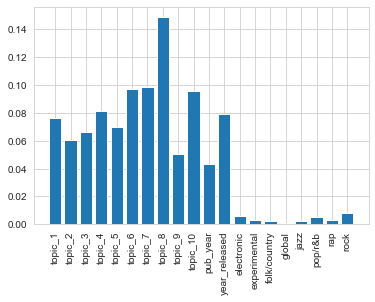

<Figure size 1440x1440 with 0 Axes>

In [149]:
plt.bar(range(len(randomforest.feature_importances_)), randomforest.feature_importances_)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], ["topic_1", "topic_2", 'topic_3', \
            'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'pub_year', 'year_released', \
            'electronic', 'experimental', 'folk/country', 'global', 'jazz', 'pop/r&b', 'rap', 'rock'], rotation=90)

plt.figure(figsize=(20,20))
plt.savefig('featureimportance.png');

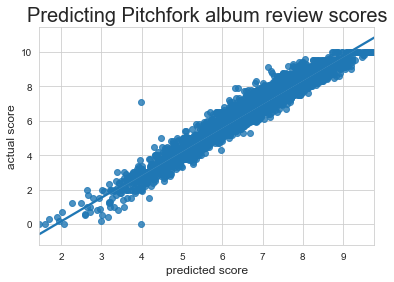

<Figure size 1440x1440 with 0 Axes>

In [105]:
sns.set_style('whitegrid') 

sns.regplot(data = topic_review_df, x=y_train_pred, y=y_train)

plt.title('Predicting Pitchfork album review scores', fontsize = 20)
plt.ylabel('actual score', fontsize=12)
plt.xlabel('predicted score', fontsize=12)

plt.figure(figsize=(20,20))
plt.savefig('AlbumPredict.png');

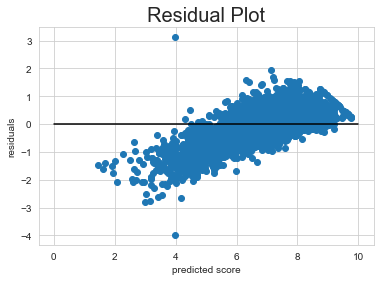

<Figure size 1440x1440 with 0 Axes>

In [104]:
residuals = y_train-y_train_pred

plt.scatter(y_train_pred, residuals)
plt.plot([0,10], [0,0], color='black')

plt.title("Residual Plot", fontsize=20)
plt.xlabel("predicted score")
plt.ylabel("residuals")
plt.figure(figsize=(20,20))
plt.savefig('Residual.png');

In [85]:
y_test_pred = randomforest.predict(X_test)

ridge_test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
ridge_test_mae = mean_absolute_error(y_test, y_test_pred)

ridge_test_r2 = randomforest.score(X_test, y_test)

print(ridge_test_rmse)
print(ridge_test_mae)
print(ridge_test_r2)

1.17892564343691
0.8911845425531916
0.1214973644462094


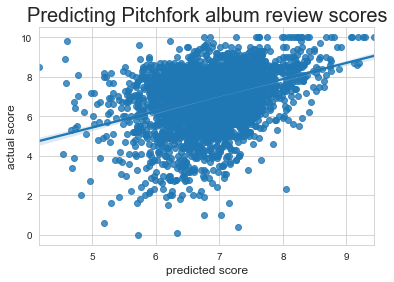

<Figure size 1080x1080 with 0 Axes>

In [86]:
sns.set_style('whitegrid') 

sns.regplot(data = topic_review_df, x=y_test_pred, y=y_test)

plt.title('Predicting Pitchfork album review scores', fontsize = 20)
plt.ylabel('actual score', fontsize=12)
plt.xlabel('predicted score', fontsize=12)

plt.figure(figsize=(15,15));

In [124]:
act_pred_df.Residual.sort_values().tail(20)

5751     2.028000
9978     2.056000
14579    2.068000
13907    2.075000
13160    2.093000
15839    2.097000
11246    2.115000
9349     2.140000
10442    2.144000
6094     2.206000
13153    2.222000
3914     2.300000
16667    2.520000
13548    2.563000
15942    2.616000
17960    2.673000
13852    2.768000
15414    2.797000
12483    3.118683
12163    3.981317
Name: Residual, dtype: float64

In [127]:
act_pred_df.loc[6094]

Actual       1.000
Predicted    3.206
Residual     2.206
Name: 6094, dtype: float64

In [126]:
allreviews_df.loc[6094]

id                                                            15996
review            When  Metallica announced last June that they ...
processed         metallica announc last june record new lou ree...
title                                                          lulu
artist                                          lou reed, metallica
url               http://pitchfork.com/reviews/albums/15996-lou-...
score                                                             1
best_new_music                                                    0
author                                                stuart berman
author_type                                             contributor
pub_date                                                 2011-11-01
pub_weekday                                                       1
pub_day                                                           1
pub_month                                                        11
pub_year                                        